In [2]:
# import pandas as pd
# import numpy as np


# df_transactions = pd.read_csv('data/transactions_data.csv')

# # small version of the dataset

# id_random = np.random.choice(df_transactions['id'].unique(), 1000000, replace=False)
# df_transactions_small = df_transactions[df_transactions['id'].isin(id_random)]

# df_transactions_small.to_csv('data/transactions_data_small.csv', index=False)


In [3]:
import json
import pandas as pd

data = json.load(open('../data/train_fraud_labels.json'))
df_transactions = pd.read_csv('../data/transactions_data_small.csv')

# Yes -> 1, No -> 0
df_transactions.pop("errors")
df_transactions.pop("card_id")


0         5131
1         1112
2         3442
3          127
4         3764
          ... 
999995    4227
999996    2509
999997    3822
999998    4357
999999    2066
Name: card_id, Length: 1000000, dtype: int64

In [4]:
df_transactions['is_fraud'] = df_transactions['id'].apply(lambda x: data["target"][str(x)] if str(x) in data["target"] else "unknown")
df_transactions = df_transactions[df_transactions['is_fraud'] != "unknown"]
df_transactions['is_fraud'] = df_transactions['is_fraud'].apply(lambda x: 1 if x == "Yes" else 0)



df_transactions["amount"] = df_transactions["amount"].apply(lambda x: x.replace("$", "")).astype(float)

amount_mean = df_transactions['amount'].mean()
amount_std = df_transactions['amount'].std()

df_transactions['amount'] = (df_transactions['amount'] - amount_mean) / amount_std

In [5]:
# count df_transactions['is_fraud']
print(df_transactions['is_fraud'].value_counts())

is_fraud
0    668312
1       985
Name: count, dtype: int64


In [6]:
ratio = df_transactions['is_fraud'].value_counts()[0] / df_transactions['is_fraud'].value_counts()[1]
print(ratio)

678.4893401015229


In [7]:
# repeat df_transactions['is_fraud'] = 1 ratio times

df_transactions = pd.concat([df_transactions] + [df_transactions[df_transactions['is_fraud'] == 1]] * int(ratio - 1))
# shuffle the dataset
df_transactions = df_transactions.sample(frac=1).reset_index(drop=True)

In [8]:
print(df_transactions['is_fraud'].value_counts())

is_fraud
0    668312
1    667830
Name: count, dtype: int64


In [9]:
# date -> day, month, year and remove date
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_transactions['day'] = df_transactions['date'].dt.day
df_transactions['month'] = df_transactions['date'].dt.month
df_transactions["hour"] = df_transactions["date"].dt.hour
df_transactions["weekday"] = df_transactions["date"].dt.weekday
df_transactions.pop("date")


0         2012-10-26 12:09:00
1         2013-04-11 16:24:00
2         2018-09-07 16:22:00
3         2019-04-09 16:52:00
4         2018-01-01 13:52:00
                  ...        
1336137   2012-08-18 13:12:00
1336138   2014-05-20 22:07:00
1336139   2016-02-11 10:25:00
1336140   2012-06-24 19:10:00
1336141   2014-01-06 03:51:00
Name: date, Length: 1336142, dtype: datetime64[ns]

In [10]:
# id and client_id are not useful
df_transactions.pop("id")
df_transactions.pop("client_id")
df_transactions.pop("zip")

0              NaN
1          17011.0
2              NaN
3              NaN
4              NaN
            ...   
1336137        NaN
1336138        NaN
1336139        NaN
1336140        NaN
1336141        NaN
Name: zip, Length: 1336142, dtype: float64

In [11]:
import pandas as pd

In [12]:
df = df_transactions

In [13]:
# Category columns
# use_chip
# merchant_id
# merchant_city
# merchant_state
# mcc
for col in ["use_chip", "merchant_id", "merchant_city", "merchant_state", "mcc"]:
    df[col] = df[col].astype('category')


In [14]:
for col in ["use_chip", "merchant_id", "merchant_city", "merchant_state", "mcc"]:
    print(f"{col}: {len(df[col].cat.categories)}")

use_chip: 3
merchant_id: 25487
merchant_city: 8239
merchant_state: 160
mcc: 109


In [15]:
# Establecer un umbral mínimo de frecuencia
min_frequency = 50  # Puedes ajustar este valor según el contexto

rare_categories = []
full_categories = []
for col in ["merchant_id", "merchant_city", "merchant_state", "mcc"]:
    # Calcular las frecuencias de cada categoría
    freq = df[col].value_counts()
    # Etiquetar como 'others' las categorías que aparecen menos de 'min_frequency' veces
    rc = freq[freq < min_frequency].index
    df[col] = df[col].cat.add_categories("others").fillna("others")
    df[col] = df[col].replace(rc, "others")
    rare_categories.append(rc)
    full_categories.append(df[col].cat.categories)


/tmp/ipykernel_13961/4121426426.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].replace(rc, "others")
/tmp/ipykernel_13961/4121426426.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].replace(rc, "others")
/tmp/ipykernel_13961/4121426426.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].re

Index(['Chip Transaction', 'Online Transaction', 'Swipe Transaction'], dtype='object')

In [16]:
for col in ["merchant_id", "merchant_city", "merchant_state", "mcc"]:
    print(f"{col}: {len(df[col].cat.categories)}")

merchant_id: 1087
merchant_city: 1599
merchant_state: 72
mcc: 105


In [17]:
df

,amount,use_chip,merchant_id,merchant_city,merchant_state,mcc,is_fraud,day,month,hour,weekday
0,-0.114609,Online Transaction,39021,ONLINE,others,4784,0,26,10,12,4
1,-0.051819,Swipe Transaction,others,Camp Hill,PA,5411,0,11,4,16,3
2,-0.382805,Chip Transaction,24504,Rome,Italy,4214,1,7,9,16,4
3,-0.355060,Chip Transaction,68751,Rome,Italy,5651,1,9,4,16,1
4,0.009876,Chip Transaction,46284,Rome,Italy,5411,1,1,1,13,0
...,...,...,...,...,...,...,...,...,...,...,...
1336137,-0.401301,Online Transaction,9932,ONLINE,others,5311,0,18,8,13,5
1336138,-0.507898,Online Transaction,16798,ONLINE,others,4121,0,20,5,22,1
1336139,0.077655,Online Transaction,47399,ONLINE,others,5815,1,11,2,10,3
1336140,0.335507,Online Transaction,99370,ONLINE,others,5311,1,24,6,19,6


In [18]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np



def one_hot_encode(pca,df_original, column):
    # Definir tamaño de los lotes
    batch_size = 10000  # Ajusta según el tamaño que la RAM permita

    # Inicializar lista para almacenar los resultados parciales
    results = []

    # Procesar el DataFrame en lotes
    for i in range(0, len(df_original), batch_size):
        # Crear lote
        df_batch = df_original.iloc[i:i + batch_size].copy()
        
        # Codificación one-hot para el lote
        df_batch = pd.get_dummies(df_batch, columns=[column])
        
        # Aplicar PCA transform en el lote
        result_batch = pca.transform(df_batch)
        
        # Guardar el resultado en la lista
        results.append(result_batch)

    # Concatenar todos los resultados
    result_full = np.vstack(results)
    return result_full

In [19]:

def PCA_one_hot(df,column, n_components,th=0.9):
    # One hot encoding

    df_original = df.copy()

    categories = df[column].cat.categories

    ind_random = np.random.permutation(100000)
    df = pd.DataFrame({column:df_original[column].iloc[ind_random]})

    df[column] = df[column].astype('category')
    df[column] = df[column].cat.set_categories(categories)
    df_one_hot = pd.get_dummies(df, columns=[column])

    # PCA
    pca = PCA(n_components=n_components)
    pca.fit(df_one_hot)
        

    er_cum = np.cumsum(pca.explained_variance_ratio_)
    # find pca.explained_variance_ratio_ > 0.05
    idx = np.where(er_cum > th)
    if  len(idx[0]) > 0:
        idx = idx[0][0]
    else:
        idx = n_components-1
    
    ncateg = df[column].cat.categories.shape[0]

    print(f"n_components = {idx+1} | n_categories = {ncateg}")

    n_components = idx+1


    df_full = pd.DataFrame({column:df_original[column]})
    result_full = one_hot_encode(pca,df_full, column)

    result_full = result_full[:, :n_components]


    df_new = pd.DataFrame(result_full, columns=[column+f"PC{i+1}" for i in range(n_components)])
    df_new.index = df_full.index

    for col in df_new.columns:
        df_original[col] = df_new[col]
    
    df_original.pop(column)

    fig = plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Principal component")
    plt.title("Cumulative explained variance ratio | n_components = "+str(n_components) + " | n_categories = "+str(ncateg) + " | columns = "+column)
    # horizontal line
    plt.axhline(y=th, color='r', linestyle='-')
    # vertical line
    plt.axvline(x=idx, color='r', linestyle='-')
    
    
    return df_original,pca, n_components
# 

In [20]:

def PCA_one_hot_apl(pca,df,column, n_components):
    # One hot encoding

    df_original = df.copy()

    df_full = pd.DataFrame({column:df_original[column]})
    result_full = one_hot_encode(pca,df_full, column)

    result_full = result_full[:, :n_components]


    df_new = pd.DataFrame(result_full, columns=[column+f"PC{i+1}" for i in range(n_components)])
    df_new.index = df_full.index

    for col in df_new.columns:
        df_original[col] = df_new[col]
    
    df_original.pop(column)

    
    return df_original
# 

n_components = 50 | n_categories = 1087
n_components = 50 | n_categories = 1599
n_components = 41 | n_categories = 105
n_components = 27 | n_categories = 72


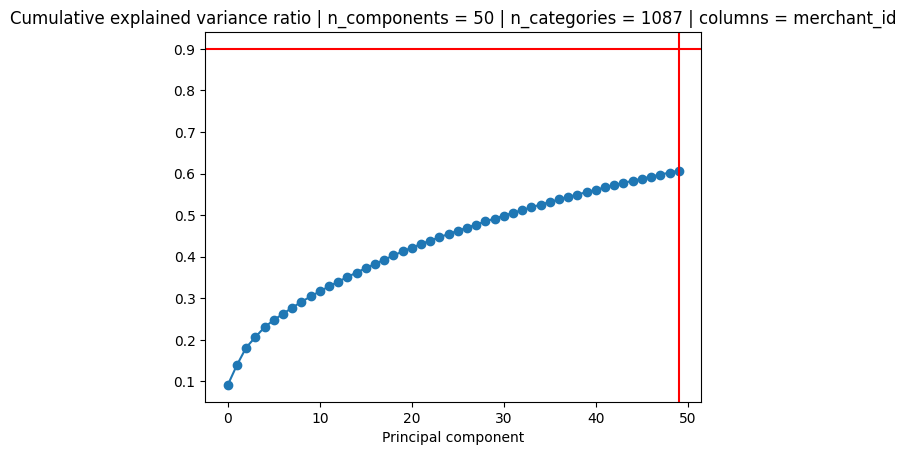

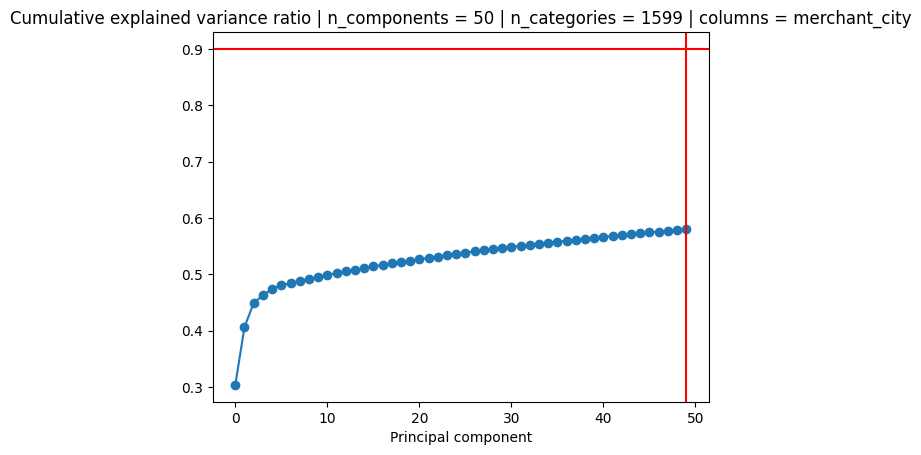

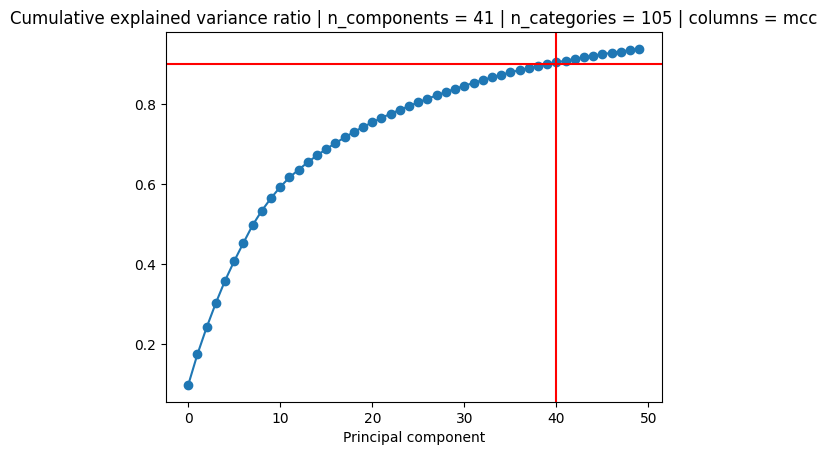

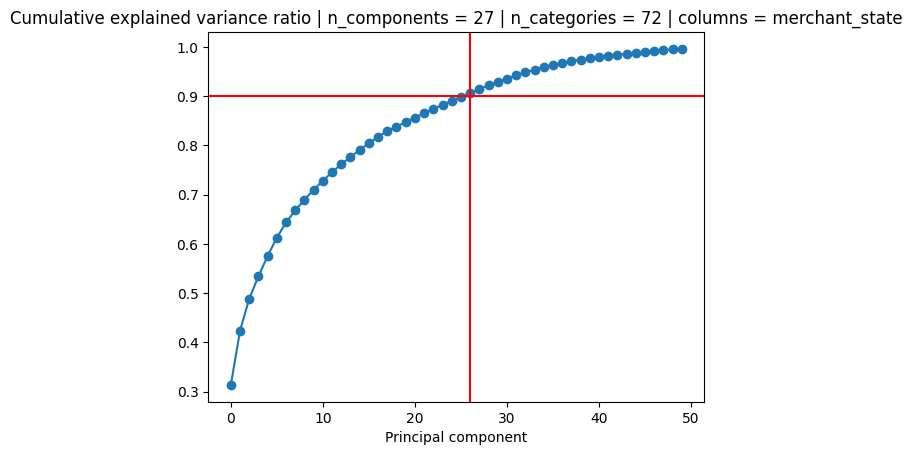

In [21]:
# Transformar los datos
pca_list = []
n_components_list = []
for col in ["merchant_id", "merchant_city", "mcc","merchant_state"]:
    df_transactions,pca, n_components = PCA_one_hot(df_transactions, col, 50)

    pca_list.append(pca)
    n_components_list.append(n_components)


In [22]:
df_transactions

,amount,use_chip,is_fraud,day,month,hour,weekday,merchant_idPC1,merchant_idPC2,merchant_idPC3,...,merchant_statePC18,merchant_statePC19,merchant_statePC20,merchant_statePC21,merchant_statePC22,merchant_statePC23,merchant_statePC24,merchant_statePC25,merchant_statePC26,merchant_statePC27
0,-0.114609,Online Transaction,0,26,10,12,4,-0.101611,-0.046927,-0.092330,...,0.001194,0.000124,0.000257,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129
1,-0.051819,Swipe Transaction,0,11,4,16,3,0.906248,0.028205,0.039307,...,0.053091,0.004777,0.009732,0.003560,0.001242,-0.001229,-0.005204,-0.006590,-0.003509,-0.004377
2,-0.382805,Chip Transaction,1,7,9,16,4,-0.085770,-0.032535,-0.059332,...,0.004778,0.000490,0.001017,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506
3,-0.355060,Chip Transaction,1,9,4,16,1,-0.083921,-0.031183,-0.056479,...,0.004778,0.000490,0.001017,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506
4,0.009876,Chip Transaction,1,1,1,13,0,-0.090928,-0.036621,-0.068201,...,0.004778,0.000490,0.001017,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336137,-0.401301,Online Transaction,0,18,8,13,5,-0.088501,-0.034637,-0.063849,...,0.001194,0.000124,0.000257,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129
1336138,-0.507898,Online Transaction,0,20,5,22,1,-0.089998,-0.035848,-0.066493,...,0.001194,0.000124,0.000257,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129
1336139,0.077655,Online Transaction,1,11,2,10,3,-0.092660,-0.038109,-0.071524,...,0.001194,0.000124,0.000257,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129
1336140,0.335507,Online Transaction,1,24,6,19,6,-0.094689,-0.039934,-0.075672,...,0.001194,0.000124,0.000257,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129


In [23]:
df_transactions = pd.get_dummies(df_transactions, columns=[ "use_chip"])


In [24]:
df_transactions 

,amount,is_fraud,day,month,hour,weekday,merchant_idPC1,merchant_idPC2,merchant_idPC3,merchant_idPC4,...,merchant_statePC21,merchant_statePC22,merchant_statePC23,merchant_statePC24,merchant_statePC25,merchant_statePC26,merchant_statePC27,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction
0,-0.114609,0,26,10,12,4,-0.101611,-0.046927,-0.092330,-0.001799,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1,-0.051819,0,11,4,16,3,0.906248,0.028205,0.039307,0.000193,...,0.003560,0.001242,-0.001229,-0.005204,-0.006590,-0.003509,-0.004377,False,False,True
2,-0.382805,1,7,9,16,4,-0.085770,-0.032535,-0.059332,-0.000664,...,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506,True,False,False
3,-0.355060,1,9,4,16,1,-0.083921,-0.031183,-0.056479,-0.000609,...,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506,True,False,False
4,0.009876,1,1,1,13,0,-0.090928,-0.036621,-0.068201,-0.000862,...,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336137,-0.401301,0,18,8,13,5,-0.088501,-0.034637,-0.063849,-0.000758,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1336138,-0.507898,0,20,5,22,1,-0.089998,-0.035848,-0.066493,-0.000820,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1336139,0.077655,1,11,2,10,3,-0.092660,-0.038109,-0.071524,-0.000949,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1336140,0.335507,1,24,6,19,6,-0.094689,-0.039934,-0.075672,-0.001073,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False


In [25]:
df_one_hot = df_transactions.copy()

In [26]:
print("Size of the dataset: ", df_one_hot.shape)

Size of the dataset:  (1336142, 177)


In [27]:
from sklearn.model_selection import train_test_split

# Variables independientes (X) y dependiente (y)
X = df_one_hot.drop('is_fraud', axis=1)
y = df_one_hot['is_fraud']

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [28]:
# count 
y_train.value_counts()

is_fraud
1    467747
0    467552
Name: count, dtype: int64

In [29]:
y_train

934710     1
397292     1
990800     1
1085166    1
1153625    1
          ..
110268     0
259178     0
131932     0
671155     0
121958     1
Name: is_fraud, Length: 935299, dtype: int64

In [30]:
X

,amount,day,month,hour,weekday,merchant_idPC1,merchant_idPC2,merchant_idPC3,merchant_idPC4,merchant_idPC5,...,merchant_statePC21,merchant_statePC22,merchant_statePC23,merchant_statePC24,merchant_statePC25,merchant_statePC26,merchant_statePC27,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction
0,-0.114609,26,10,12,4,-0.101611,-0.046927,-0.092330,-0.001799,-0.118625,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1,-0.051819,11,4,16,3,0.906248,0.028205,0.039307,0.000193,0.010634,...,0.003560,0.001242,-0.001229,-0.005204,-0.006590,-0.003509,-0.004377,False,False,True
2,-0.382805,7,9,16,4,-0.085770,-0.032535,-0.059332,-0.000664,-0.039299,...,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506,True,False,False
3,-0.355060,9,4,16,1,-0.083921,-0.031183,-0.056479,-0.000609,-0.035904,...,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506,True,False,False
4,0.009876,1,1,13,0,-0.090928,-0.036621,-0.068201,-0.000862,-0.051935,...,0.000383,0.000135,-0.000134,-0.000576,-0.000743,-0.000401,-0.000506,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336137,-0.401301,18,8,13,5,-0.088501,-0.034637,-0.063849,-0.000758,-0.045293,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1336138,-0.507898,20,5,22,1,-0.089998,-0.035848,-0.066493,-0.000820,-0.049216,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1336139,0.077655,11,2,10,3,-0.092660,-0.038109,-0.071524,-0.000949,-0.057702,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False
1336140,0.335507,24,6,19,6,-0.094689,-0.039934,-0.075672,-0.001073,-0.065939,...,0.000097,0.000034,-0.000034,-0.000146,-0.000189,-0.000102,-0.000129,False,True,False


In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supongamos que X e y representan tu dataset de características y etiquetas
# Calcular los parámetros de escalado sobre el dataset completo
scaler = StandardScaler()
scaler.fit(X)  # Ajusta el escalador con el dataset completo

# Definir el modelo MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=100, warm_start=True)

# Definir las clases del modelo (es importante para partial_fit)
classes = np.unique(y)

# Dividir el dataset en chunks y entrenar con partial_fit
chunk_size = 100000  # Define el tamaño del chunk

def get_chunks(X, y, chunk_size):
    
    id_random = np.random.permutation(chunk_size)
    X = X.iloc[id_random]
    y = y.iloc[id_random]

    return X, y

for i in range(0, len(X), chunk_size):
    
    # Obtener el chunk actual
    X_chunk, y_chunk = get_chunks(X_train, y_train, chunk_size)
    
    # Aplicar la normalización a cada chunk utilizando el escalador ajustado
    X_chunk = scaler.transform(X_chunk)
    
    # Entrenamiento incremental en el chunk actual
    model.partial_fit(X_chunk, y_chunk, classes=classes)
    print(f"Chunk {i} trained on {chunk_size} samples")


Chunk 0 trained on 100000 samples
Chunk 100000 trained on 100000 samples
Chunk 200000 trained on 100000 samples
Chunk 300000 trained on 100000 samples
Chunk 400000 trained on 100000 samples
Chunk 500000 trained on 100000 samples
Chunk 600000 trained on 100000 samples
Chunk 700000 trained on 100000 samples
Chunk 800000 trained on 100000 samples
Chunk 900000 trained on 100000 samples
Chunk 1000000 trained on 100000 samples
Chunk 1100000 trained on 100000 samples
Chunk 1200000 trained on 100000 samples
Chunk 1300000 trained on 100000 samples


In [32]:

# Predicciones
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)


In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del modelo:", accuracy)


Exactitud del modelo: 0.9960408439214355


In [34]:

# Matriz de confusión
print("Matriz de Confusión:")
mc = confusion_matrix(y_test, y_pred)

print("Verdaderos positivos:", mc[0][0])
print("Falsos positivos:", mc[0][1])
print("Falsos negativos:", mc[1][0])
print("Verdaderos negativos:", mc[1][1])




Matriz de Confusión:
Verdaderos positivos: 199375
Falsos positivos: 1385
Falsos negativos: 202
Verdaderos negativos: 199881


In [35]:

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    200760
           1       0.99      1.00      1.00    200083

    accuracy                           1.00    400843
   macro avg       1.00      1.00      1.00    400843
weighted avg       1.00      1.00      1.00    400843



In [45]:
metadata = {
    "amount_mean": amount_mean,
    "amount_std": amount_std,
    "pca_list": pca_list,
    "n_components_list": n_components_list,
    "full_categories": full_categories,
    "model": model,
    "scaler": scaler,
    "use_chip_categories": df["use_chip"].cat.categories,
}

import pickle

with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
    